In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Импортируем необходимые библиотеки для выполнения задачи***

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

import warnings
warnings.filterwarnings("ignore")

***Загрузка наборов данных***

In [3]:
shop_metrics_new = pd.read_csv('/content/drive/MyDrive/研一_A_B测试和可靠的ML/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('/content/drive/MyDrive/研一_A_B测试和可靠的ML/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('/content/drive/MyDrive/研一_A_B测试和可靠的ML/shop_df_users.csv').drop(columns='Unnamed: 0')

In [4]:
shop_metrics_new.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


In [5]:
shop_metrics_old.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


***Метрики:***
   - ***is_viewed - айтем товара просмотрен***
   - ***products_viewed_cnt - количество уникальных просмотренных айтемов***
   - ***price_sum - суммарная цена товаров***
   - ***is_cart_added - товар добавлен в корзину***
   - ***is_purchased - товар куплен***
   - ***cart_added_cnt - количество товаров, добавленных в корзину***
   - ***purchased_cnt - количество купленных товаров***

In [6]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

# '''os.urandom() method is used to generate a string of size random bytes suitable for cryptographic use
#    or we can say this method generates a string containing random characters.'''
# https://www.geeksforgeeks.org/python-os-urandom-method/

In [7]:
def groups_splitter(df, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

# **1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:**

- метрике cart_added_cnt (1 балл)

In [8]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

In [9]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')
ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,100038.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,100038.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,100038.5
...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,100038.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,100038.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,100038.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,100038.5


In [10]:
ranked[ranked['cart_added_cnt'] > 0]

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
13,1515915625353706476,A,1,12,522.75,0.0,0.0,2,0,219885.0
33,1515915625355805313,A,1,4,1336.40,0.0,0.0,1,0,209349.0
36,1515915625356129712,A,1,4,144.42,0.0,0.0,1,0,209349.0
108,1515915625367976920,A,1,4,144.83,0.0,0.0,1,1,209349.0
113,1515915625368720412,A,1,2,425.56,0.0,0.0,1,0,209349.0
...,...,...,...,...,...,...,...,...,...,...
222375,1515915625611002957,B,1,1,490.54,0.0,0.0,1,0,209349.0
222403,1515915625611007170,B,1,1,839.75,0.0,0.0,1,0,209349.0
222424,1515915625611010717,B,1,3,1493.89,0.0,0.0,2,0,219885.0
222440,1515915625611013140,B,1,2,642.29,0.0,0.0,2,0,219885.0


In [11]:
print(ranked[ranked.group == 'A']['rank'].mean(),
   ranked[ranked.group == 'B']['rank'].mean(),
  ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) /
   ranked[ranked.group == 'A']['rank'].mean()*100))

111170.45633348604 111351.6421897482 0.16298022175842064


In [12]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916, df=222519.0)

In [13]:
stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                  shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

***Получается, что t-тест и тест Манна-Уитни получили схожие результаты с p-value около 0,2025.***

# **2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:**

- обычной метрике cart_added_cnt
- логарфимированной метрике cart_added_cnt
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (3 балла)

*В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped*

In [14]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

In [15]:
shop_metrics_old.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


### ***Обычная метрика cart_added_cnt***

In [19]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')

In [24]:
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

In [25]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [26]:
shop_metrics_all_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.132761


In [27]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
        shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

TtestResult(statistic=-1.3855896128447498, pvalue=0.16587364048767594, df=222519.0)

In [28]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
    метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
    метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')

метрика_cuped A: 0.136382315726573,     метрика_cuped B: 0.1372102898471418
метрика без cuped A: 0.1350419058398685,     метрика без cuped B: 0.1385521582733813


In [29]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
    метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
    метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')

метрика_cuped A: 0.01823518359964534,     метрика_cuped B: 0.02149536345539653
метрика без cuped A: 0.3805867322090304,     метрика без cuped B: 0.4247189893567569


In [30]:
shop = shop_metrics_new.drop(columns=['group'])

100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


 power: 100.0% , correctness: 97.0%


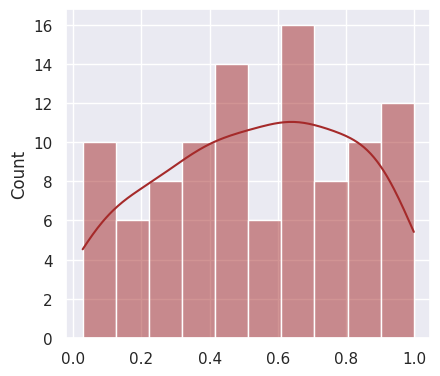

In [107]:
# мощность и корректность для CUPED

correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

***Обычная метрика cart_added_cnt:***

***T-тест: statistic = -1.386, p-value = 0.166***

***для CUPED:***

***Мощность: 100%, Корректность: 97%***


### ***Логарфимированная метрика cart_added_cnt***

In [32]:
shop_metrics_all['log_cart_added_cnt'] = np.log1p(shop_metrics_all['cart_added_cnt'])
shop_metrics_all['log_cart_added_cnt_covariate'] = np.log1p(shop_metrics_all['cart_added_cnt_covariate'])

In [33]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['log_cart_added_cnt'])
shop_metrics_all_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,log_cart_added_cnt,log_cart_added_cnt_covariate,log_cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.0,0.0,0.080004
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.0,0.0,0.080004
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.0,0.0,0.080004
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.0,0.0,0.080004
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.0,0.0,0.080004


In [34]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['log_cart_added_cnt_cuped'],
        shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['log_cart_added_cnt_cuped'])

TtestResult(statistic=-2.0493551017035605, pvalue=0.04042857406821207, df=222519.0)

In [35]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["log_cart_added_cnt_cuped"].mean()}, \
    метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["log_cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["log_cart_added_cnt_cuped"].mean()}, \
    метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["log_cart_added_cnt_cuped"].mean()}')

метрика_cuped A: 0.08034157852348373,     метрика_cuped B: 0.08072086382541538
метрика без cuped A: 0.08034157852348373,     метрика без cuped B: 0.08072086382541538


In [36]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["log_cart_added_cnt_cuped"].var()}, \
    метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["log_cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["log_cart_added_cnt_cuped"].var()}, \
    метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["log_cart_added_cnt_cuped"].var()}')

метрика_cuped A: 0.0020550143786429147,     метрика_cuped B: 0.0017558187333519101
метрика без cuped A: 0.0020550143786429147,     метрика без cuped B: 0.0017558187333519101


100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


 power: 100.0% , correctness: 94.0%


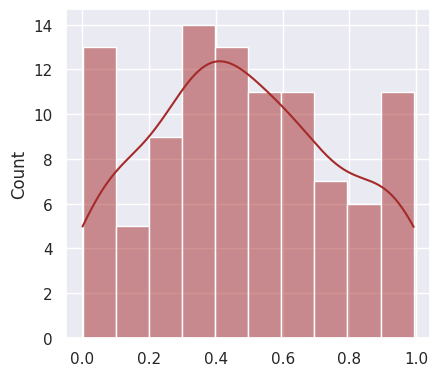

In [114]:
# мощность и корректность для CUPED

correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    all_df['log_cart_added_cnt'] = np.log1p(all_df['cart_added_cnt'])
    all_df['log_cart_added_cnt_covariate'] = np.log1p(all_df['cart_added_cnt_covariate'])

    cuped_df = cuped_transform(all_df, ['log_cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['log_cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['log_cart_added_cnt_cuped']

    vec_b_effect = vec_b * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

***Логарфимированная метрика cart_added_cnt:***

***T-тест: statistic = -2.049, p-value = 0.040***

***для CUPED:***

***Мощность: 100%, Корректность: 94%***

### ***Метрике cart_added_cnt (а после подвергнуть ранговому преобразованию)***

In [38]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [39]:
ranked = rank_transformation(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], 'cart_added_cnt_cuped')
ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761,100501.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761,100501.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761,100501.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,0,0.132761,100501.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,0,0.132761,100501.5
...,...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0,0.132761,100501.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0,0.132761,100501.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0,0.132761,100501.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0,0.132761,100501.5


In [40]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'],
        ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.4459909525623789, pvalue=0.14818114788143422, df=222519.0)

In [41]:
print(f'метрика_cuped A: {ranked[ranked.group == "A"]["cart_added_cnt_cuped"].mean()}, \
    метрика_cuped B: {ranked[ranked.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {ranked[ranked.group == "A"]["cart_added_cnt"].mean()}, \
    метрика без cuped B: {ranked[ranked.group == "B"]["cart_added_cnt"].mean()}')

метрика_cuped A: 0.136382315726573,     метрика_cuped B: 0.1372102898471418
метрика без cuped A: 0.1350419058398685,     метрика без cuped B: 0.1385521582733813


In [42]:
print(f'метрика_cuped A: {ranked[ranked.group == "A"]["cart_added_cnt_cuped"].var()}, \
    метрика_cuped B: {ranked[ranked.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {ranked[ranked.group == "A"]["cart_added_cnt"].var()}, \
    метрика без cuped B: {ranked[ranked.group == "B"]["cart_added_cnt"].var()}')

метрика_cuped A: 0.01823518359964534,     метрика_cuped B: 0.02149536345539653
метрика без cuped A: 0.3805867322090304,     метрика без cuped B: 0.4247189893567569


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


 power: 100.0% , correctness: 94.0%


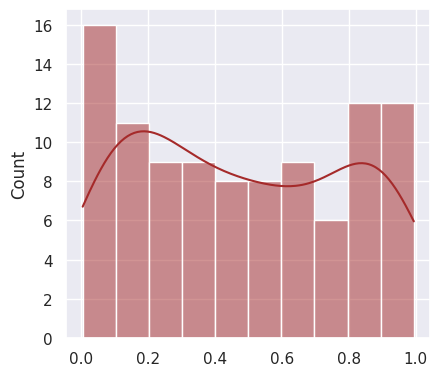

In [144]:
# мощность и корректность для CUPED

correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    ranked_df = rank_transformation(cuped_df[cuped_df.group == 'A'],
                     cuped_df[cuped_df.group == 'B'], 'cart_added_cnt_cuped')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = cuped_df[cuped_df['group'] == 'B']['cart_added_cnt_cuped'] * 1.05
    new_df_b = cuped_df[cuped_df.group == 'B'].drop(columns=['cart_added_cnt_cuped'])
    new_df_b['cart_added_cnt_cuped'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(cuped_df[cuped_df.group == 'A'], new_df_b, 'cart_added_cnt_cuped')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)


correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

***Метрике cart_added_cnt (а после подвергнуть ранговому преобразованию):***

***T-тест: statistic = -1.446, p-value = 0.148***

***для CUPED:***

***Мощность: 100%, Корректность: 94%***

# **3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:**

- на логнормальном распределении (сгенерированные данные)

- на метрике cart_added_cnt (2 балла)

In [19]:
shop_metrics_new.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


In [24]:
import pandas as pd
import scipy.stats as stats

num_buckets = 15
_, bin_edges = pd.qcut(shop_metrics_new['cart_added_cnt'], q=num_buckets, duplicates='drop', retbins=True)

shop_metrics_new['bucket'] = pd.cut(shop_metrics_new['cart_added_cnt'], bins=bin_edges, labels=False)
non_empty_buckets = shop_metrics_new['bucket'].dropna().unique()
shop_metrics_new = shop_metrics_new[shop_metrics_new['bucket'].isin(non_empty_buckets)]
bucket_means = shop_metrics_new.groupby('bucket')['cart_added_cnt'].mean()

if len(non_empty_buckets) > 1:
    buckets_data = [shop_metrics_new[shop_metrics_new['bucket'] == i]['cart_added_cnt'].values for i in non_empty_buckets]
    t_stat, p_value = stats.f_oneway(*buckets_data)
    print('t-test между бакетами:')
    print(f'F-статистика: {round(t_stat, 5)}, p-value: {round(p_value, 5)}')
else:
    print('Недостаточно данных для t-test между бакетами (менее двух бакетов)')
print('Средние в каждом бакете:')
bucket_means

t-test между бакетами:
F-статистика: 107.79286, p-value: 0.0
Средние в каждом бакете:


bucket
0.0     5.000000
1.0     6.000000
2.0     7.000000
3.0     8.000000
4.0     9.260870
5.0    11.658537
6.0    24.043478
Name: cart_added_cnt, dtype: float64

# **4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:**
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая (2 балла)

In [8]:
shop_users_info.head()

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m


In [9]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=['user_id'], how='left')

In [10]:
shop_w_features['age_group'] = pd.cut(
    shop_w_features['user_age'],
    bins=[18, 25, 45, 60, 75, np.inf],
    labels=['18-24', '25-45', '46-60', '61-75', '76+'],
    right=False
)

result = shop_w_features.groupby(['group', 'age_group'], sort=False)['age_group'].count()
print(result)

group  age_group
A      18-24        21393
       25-45        60951
       46-60        45636
       61-75        44913
       76+          30443
B      18-24        21265
       25-45        60907
       46-60        45458
       61-75        45420
       76+          30477
Name: age_group, dtype: int64


In [15]:
t_stat_unstrat, p_value_unstrat = stats.ttest_ind(
    shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'],
    shop_w_features[shop_w_features.group == 'B']['cart_added_cnt']
)

relative_change_unstrat = (
    shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].mean() -
    shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean()
) / shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean() * 100

std_a_unstrat = shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].std()
std_b_unstrat = shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].std()

print(f"Стандартное отклонение A: {round(std_a_unstrat, 5)}")
print(f"Стандартное отклонение B: {round(std_b_unstrat, 5)}")
print(f"Относительное изменение среднего: {round(relative_change_unstrat, 5)}%")

Стандартное отклонение A: 0.57669
Стандартное отклонение B: 0.59876
Относительное изменение среднего: 1.12427%


In [12]:
strats_weights = shop_w_features.groupby('age_group').size() / len(shop_w_features)

mean_a = (
    shop_w_features[shop_w_features.group == 'A']
    .groupby('age_group')['cart_added_cnt']
    .mean()
    .multiply(strats_weights)
    .sum()
)

mean_b = (
    shop_w_features[shop_w_features.group == 'B']
    .groupby('age_group')['cart_added_cnt']
    .mean()
    .multiply(strats_weights)
    .sum()
)

std_a = (
    shop_w_features[shop_w_features.group == 'A']
    .groupby('age_group')['cart_added_cnt']
    .std()
    .pow(2)
    .multiply(strats_weights)
    .sum()
)

std_b = (
    shop_w_features[shop_w_features.group == 'B']
    .groupby('age_group')['cart_added_cnt']
    .std()
    .pow(2)
    .multiply(strats_weights)
    .sum()
)

n_a = shop_w_features[shop_w_features.group == 'A'].groupby('age_group').size().sum()
n_b = shop_w_features[shop_w_features.group == 'B'].groupby('age_group').size().sum()

effect = round((mean_b - mean_a) / mean_a * 100, 5)
std_a = round(std_a, 5)
std_b = round(std_b, 5)
print(f'Эффект: {effect}, std_a: {std_a}, std_b: {std_b}')

Эффект: 1.1249, std_a: 0.33272, std_b: 0.35866


In [16]:
t_stat_strat, p_value_strat = stats.ttest_ind_from_stats(
    mean_a, np.sqrt(std_a), n_a,
    mean_b, np.sqrt(std_b), n_b
)

print("t-test без постстратификации:")
print(f"F-статистика: {round(t_stat_unstrat, 5)}, p-value: {round(p_value_unstrat, 5)}")
print("\nt-test с постстратификацией:")
print(f"F-статистика: {round(t_stat_strat, 5)}, p-value: {round(p_value_strat, 5)}")

t-test без постстратификации:
F-статистика: -0.73319, p-value: 0.46344

t-test с постстратификацией:
F-статистика: -0.73345, p-value: 0.46328


***Из приведенных выше результатов видно, что без постстратификации и с постстратификацией оказывают незначительное влияние на результаты теста.***